In [4]:
#import libraries 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Load Data & Initial Inspection
# ------------------------------
df = pd.read_csv('../data/amazon_sales_dataset.csv')
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
df.info()
print("\nFirst 5 rows:")
df.head()


Shape: (50000, 13)

Columns: ['order_id', 'order_date', 'product_id', 'product_category', 'price', 'discount_percent', 'quantity_sold', 'customer_region', 'payment_method', 'rating', 'review_count', 'discounted_price', 'total_revenue']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          50000 non-null  int64  
 1   order_date        50000 non-null  object 
 2   product_id        50000 non-null  int64  
 3   product_category  50000 non-null  object 
 4   price             50000 non-null  float64
 5   discount_percent  50000 non-null  int64  
 6   quantity_sold     50000 non-null  int64  
 7   customer_region   50000 non-null  object 
 8   payment_method    50000 non-null  object 
 9   rating            50000 non-null  float64
 10  review_count      50000 non-null  int64  
 11  discounted_price  50000 non-null

,order_id,order_date,product_id,product_category,price,discount_percent,quantity_sold,customer_region,payment_method,rating,review_count,discounted_price,total_revenue
0,1,2022-04-13,2637,Books,128.75,10,4,North America,UPI,3.5,443,115.88,463.52
1,2,2023-03-12,2300,Fashion,302.60,20,5,Asia,Credit Card,3.7,475,242.08,1210.40
2,3,2022-09-28,3670,Sports,495.80,20,2,Europe,UPI,4.4,183,396.64,793.28
3,4,2022-04-17,2522,Books,371.95,15,4,Middle East,UPI,5.0,212,316.16,1264.64
4,5,2022-03-13,1717,Beauty,201.68,0,4,Middle East,UPI,4.6,308,201.68,806.72


In [5]:
# 2. Check for Missing Values 

missing = df.isnull().sum()
print("\nMissing values per column:\n", missing[missing>0])
# There appear to be no missing values, but we'll confirm.
# If any, impute appropriately. For demonstration, we assume none.



Missing values per column:
 Series([], dtype: int64)


In [6]:
# 3. Data Type Correction & Feature Engineering 

# Convert order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Extract temporal features
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df['day_of_week'] = df['order_date'].dt.dayofweek  # Monday=0

# Verify derived columns
print(df[['order_date', 'year', 'month', 'day', 'day_of_week']].head()) 


  order_date  year  month  day  day_of_week
0 2022-04-13  2022      4   13            2
1 2023-03-12  2023      3   12            6
2 2022-09-28  2022      9   28            2
3 2022-04-17  2022      4   17            6
4 2022-03-13  2022      3   13            6


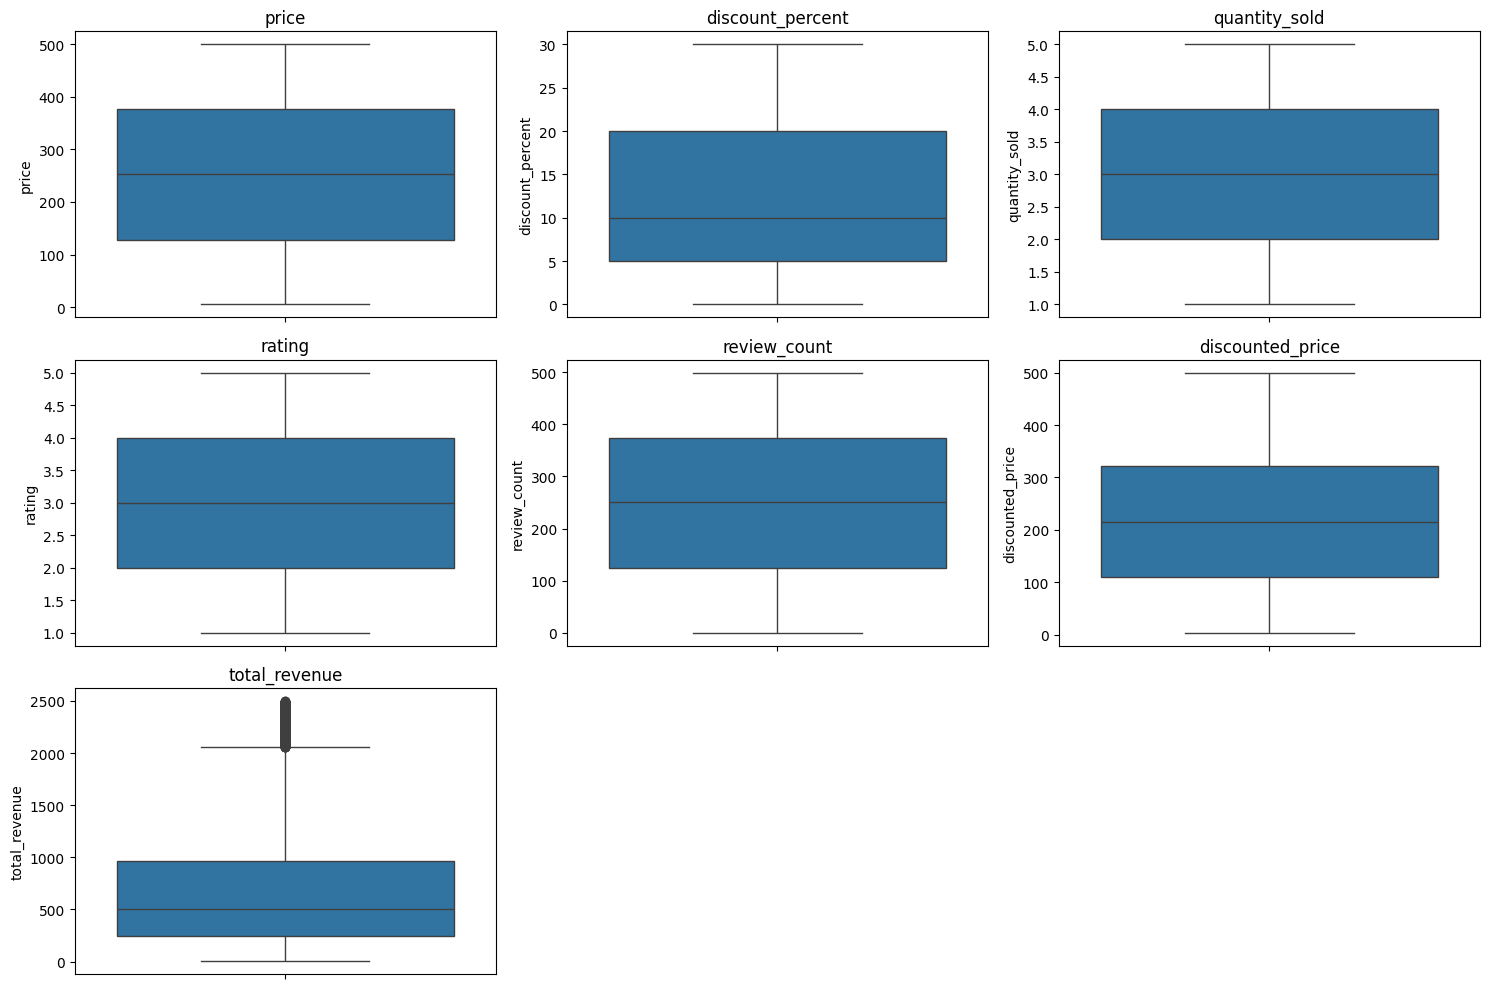

In [7]:
# 4. Outlier Detection & Treatment 

numeric_cols = ['price', 'discount_percent', 'quantity_sold', 'rating', 'review_count', 
                'discounted_price', 'total_revenue']

# Visualize distributions
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3,3,i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Identify outliers using IQR and cap them (Winsorization)
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower_bound, upper_bound)
    return df

for col in numeric_cols:
    df = cap_outliers(df, col)

In [8]:
# 5. Logical Consistency Checks 

# Ensure discounted_price <= price (discount >= 0)
df['discount_check'] = df['discounted_price'] <= df['price']
print("Rows where discounted_price > price:\n", df[~df['discount_check']])
# None should be found. If any, we could fix by recomputing.

# Recompute discounted_price to be sure (should match original)
df['computed_discounted_price'] = df['price'] * (1 - df['discount_percent']/100)
df['price_diff'] = np.abs(df['computed_discounted_price'] - df['discounted_price']).round(2)
print("Max price difference:", df['price_diff'].max())
# Should be 0 (floating rounding may cause small diff). If large, adjust.

# Remove helper columns after check
df.drop(['discount_check', 'computed_discounted_price', 'price_diff'], axis=1, inplace=True) 

Rows where discounted_price > price:
 Empty DataFrame
Columns: [order_id, order_date, product_id, product_category, price, discount_percent, quantity_sold, customer_region, payment_method, rating, review_count, discounted_price, total_revenue, year, month, day, day_of_week, discount_check]
Index: []
Max price difference: 0.01


In [ ]:
# 6. Save Cleaned Data 

df.to_csv('amazon_sales_cleaned.csv', index=False)
print("Cleaned dataset saved as 'amazon_sales_cleaned.csv'.")